In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pylab as plt
from tools import Config, turn_raw_dat_to_sorted_arrays
from tools_evo_dyn import tau_leap_symbiosis_mutation

In [2]:
cg_evo_1 =  Config(dict(eta = 1., g = 0.312, mu = 1.4, alpha = 1.2, gamma = 1.23, p = 0.1, beta = 2.1,
                        r = 2.3, d = 1.3, theta = 8., v = 1., h = 1.5, nu_max = 3))

In [3]:
np.random.seed(2)
V = 100
init = np.array([0.1, 1., 0.2])
ds_1 = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 2000000, dt = 1, cg = cg_evo_1, V = V, 
                                         trait_init = np.array([2, -0.5]), sigma_rho = 0.5, sigma_nu = 0.2, 
                                         mutant_rate = 0.001, step = 200)

/Users/phuongnguyen/Work/symbiosis_3D_tradeoff/tools.py:72: RuntimeWarning: invalid value encountered in power
  return cg.theta - cg.v * rho**cg.h + (cg.eta * nu * (nu + cg.d) ** cg.g) / cg.nu_max


In [9]:
dss_1 = turn_raw_dat_to_sorted_arrays(ds_1)

Text(0.5, 1.0, 'Bound reproduction $\\tau$')

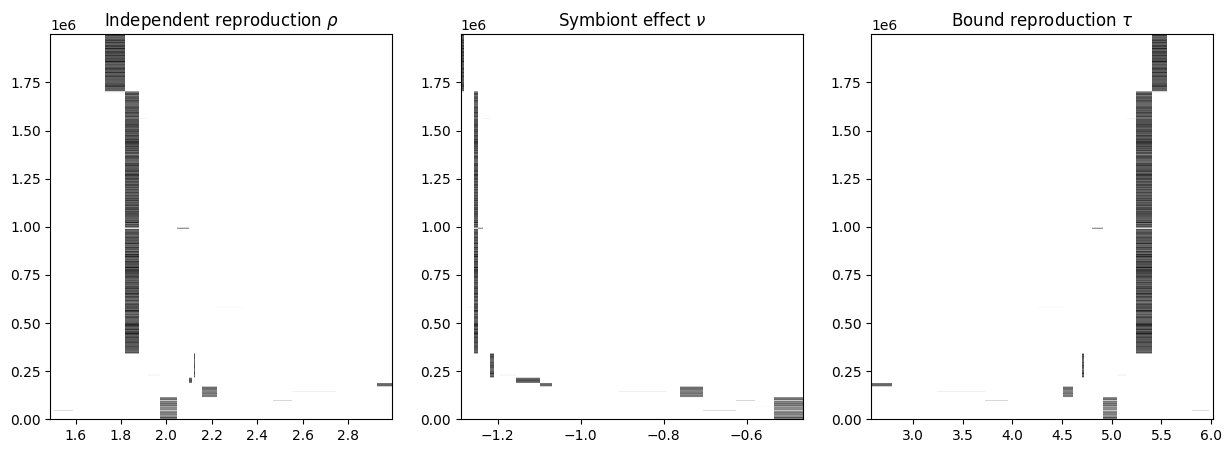

In [10]:
popmin_thres = 20
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
cc = np.where(np.sum(dss_1["xF_rho"] > popmin_thres, axis = 0) > 0)
ZZ = dss_1["xF_rho"][:, cc[0]]
XX, YY = np.meshgrid(dss_1["rho_sort"][cc[0]], ds_1["t"])
axes[0].pcolormesh(XX, YY, ZZ/V, cmap = "Greys")
axes[0].set_title(r"Independent reproduction $\rho$")
cc = np.where(np.sum(dss_1["xF_nu"] > popmin_thres, axis = 0) > 0)
ZZ = dss_1["xF_nu"][:, cc[0]]
XX, YY = np.meshgrid(dss_1["nu_sort"][cc[0]], ds_1["t"])
axes[1].pcolormesh(XX, YY, ZZ, cmap = "Greys")
axes[1].set_title(r"Symbiont effect $\nu$")
cc = np.where(np.sum(dss_1["xF_tau"] > popmin_thres, axis = 0) > 0)
ZZ = dss_1["xF_tau"][:, cc[0]]
XX, YY = np.meshgrid(dss_1["tau_sort"][cc[0]], ds_1["t"])
axes[2].pcolormesh(XX, YY, ZZ, cmap = "Greys")
axes[2].set_title(r"Bound reproduction $\tau$")

In [11]:
np.random.seed(10)
V = 200
init = np.array([0.1, 1., 0.2])
ds_2 = tau_leap_symbiosis_mutation(pop_init = init * V, Tmax = 2000000, dt = 1, cg = cg_evo_1, V = V, 
                                         trait_init = np.array([3, 1]), sigma_rho = 0.5, sigma_nu = 0.2, 
                                         mutant_rate = 0.005, step = 5)

Simulation stop at time step 66655 as Fs = [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0

In [7]:
dss_2 = turn_raw_dat_to_sorted_arrays(ds_2)

Text(0.5, 1.0, 'Bound reproduction $\\tau$')

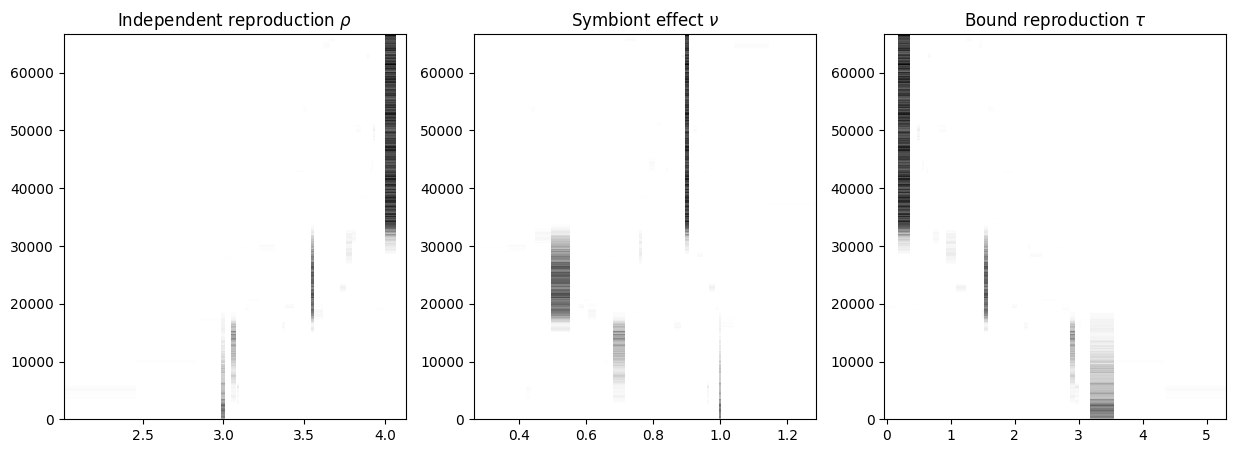

In [8]:
popmin_thres = 10
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
cc = np.where(np.sum(dss_2["xF_rho"] > popmin_thres, axis = 0) > 0)
ZZ = dss_2["xF_rho"][:, cc[0]]
XX, YY = np.meshgrid(dss_2["rho_sort"][cc[0]], ds_2["t"])
axes[0].pcolormesh(XX, YY, ZZ/V, cmap = "Greys")
axes[0].set_title(r"Independent reproduction $\rho$")
cc = np.where(np.sum(dss_2["xF_nu"] > popmin_thres, axis = 0) > 0)
ZZ = dss_2["xF_nu"][:, cc[0]]
XX, YY = np.meshgrid(dss_2["nu_sort"][cc[0]], ds_2["t"])
axes[1].pcolormesh(XX, YY, ZZ, cmap = "Greys")
axes[1].set_title(r"Symbiont effect $\nu$")
cc = np.where(np.sum(dss_2["xF_tau"] > popmin_thres, axis = 0) > 0)
ZZ = dss_2["xF_tau"][:, cc[0]]
XX, YY = np.meshgrid(dss_2["tau_sort"][cc[0]], ds_2["t"])
axes[2].pcolormesh(XX, YY, ZZ, cmap = "Greys")
axes[2].set_title(r"Bound reproduction $\tau$")